# Clasificación de textos cortos en emociones

## Contexto:
El análisis de sentimientos es un área que genera valor en múltiples industrias. Usualmente se utilizan técnicas de NLP para clasificar rápidamente textos en un sentimiento positivo, negativo o neutral. Sin embargo, esta clasificación es bastante limitada y no permite un entendimiento profundo. Por esto, se requiere clasificar textos cortos en un espectro de emociones.

Para este caso se abordan las emociones desde un punto de vista clásico en el cual se clasifican en 7 emociones principales: 
1) `shame` = vergüenza
2) `sadness` = tristeza
3) `joy` = alegría
4) `guilt` = culpa
5) `fear` = miedo
6) `disgust` = asco
7) `anger` = ira

Se utiliza el conjunto de datos **ISEAR**, que consiste de 7666 encuestas realizadas por múltiples psicológos en los años 90 en varios países. La encuesta consistía en presentarle una emoción al entrevistado y este debía responder una situación que representara dicha emoción. Este dataset fue elegido porque ha sido ampliamente utilizado para entrenar y comparar el rendimiento de modelos en la detección de emociones.

## Objetivo:
El objetivo de este Notebook es evaluar el rendimiento de diferentes modelos para la clasificación del texto en emociones.

## Procedimiento:
Se van a evaluar el rendimiento de modelos correspondientes a diferentes técnicas: técnicas de **machine learning**, técnicas de **redes neuronales** y **transformers**

# Modelos de Machine Learning

## 0. Libraries and input data

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer


nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /home/dalopeza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dalopeza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/dalopeza/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dalopeza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim.downloader as api
from gensim.models import Word2Vec, FastText
from sklearn.tree import DecisionTreeClassifier
import warnings
from tqdm import tqdm
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Técnicas de Machine Learning

Se van a utilizar los modelos de `support vector machine`, `decision tree classifier` y `random forests classifier` para realizar un proceso de clasificación multiclase. Adicionalmente, se van a comparar los resultados con un modelo dummy como línea base.

## 1. Split dataset into train, test and validation

Se cargan los conjuntos de datos previamente separados en train, validation y test de manera aleatoria y balanceada

In [15]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv")
df_val = pd.read_csv("../data/data_to_model/val_data.csv")
df_test = pd.read_csv("../data/data_to_model/test_data.csv")

In [16]:
print(df_test.shape[0])
df_test.head()

754


,text,emotion
0,when a friend carelessly broke and object in m...,anger
1,when i felt powerless to help the poor or when...,sadness
2,one of my best friends'fianct broke off the re...,shame
3,i hadn't been at my parent's place for a long ...,sadness
4,when i didn't notify someone that he was summo...,guilt


In [17]:
print(df_val.shape[0])
df_val.head()

753


,text,emotion
0,when caught shop-lifting as for shame,guilt
1,i realised that someone was insidiously attemp...,disgust
2,the carterer refused to give me sugar to add t...,disgust
3,i was severely reprimanded for a trivial offen...,shame
4,i found myself a place after looking for one f...,joy


In [18]:
print(df_train.shape[0])
df_train.head()

6027


,text,emotion
0,when the week for exams came i got afraid as t...,fear
1,i was sleeping when i heard the neighbours scr...,fear
2,there was a time when my room looked terribly ...,shame
3,when my friend told me that he would come and ...,joy
4,"when i saw the film ""johnny got his gun"" which...",sadness


## 2. Pre-Process the text data.

### 2.1. Function to Pre-process the text data


Antes de enviar los textos a los modelos de Machine Learning se debe realizar algunas transformaciones. Se pruebas dos métodos para preprocesar la data:
El primero realizar transformaciones clásicas en NLP como remover stop-words, lemmantización y otros para evitar que los modelos aprendan de palabras que son muy comunes y que no agregan valor a la predicción.
La segunda solo tokeniza el texto y remueve stop words.

In [21]:
def preprocess_text_1(text, stemmer):
    if stemmer == "porter":
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words("english"))
        tokens_text = [w.lower() for w in tokens if len(w) > 1]
        tokens_text = [w for w in tokens_text if w.isalpha()]
        tokens_text = [w for w in tokens_text if w not in stop_words]
        porter = PorterStemmer()
        tokens_text_porter = [porter.stem(w) for w in tokens_text]
        wordnet_lemmatizer = WordNetLemmatizer()
        tokens_text = [wordnet_lemmatizer.lemmatize(w) for w in tokens_text_porter]
        return " ".join(tokens_text)

    elif stemmer == "lancaster":
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words("english"))
        tokens_text = [w.lower() for w in tokens if len(w) > 1]
        tokens_text = [w for w in tokens_text if w.isalpha()]
        tokens_text = [w for w in tokens_text if w not in stop_words]
        lancaster = LancasterStemmer()
        tokens_text_porter = [lancaster.stem(w) for w in tokens_text]
        wordnet_lemmatizer = WordNetLemmatizer()
        tokens_text = [wordnet_lemmatizer.lemmatize(w) for w in tokens_text_porter]
        return " ".join(tokens_text)

    else:
        pass
        print("No stemmer method defined")

In [22]:
def preprocess_text_2(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    tokens_text = [w for w in tokens if w not in stop_words]
    return " ".join(tokens_text)

### 2.2. Functions to vectorize the text

Los textos se deben convertir en representaciones númericas para que puedan ser interpretados por los modelos. Se va a probar la eficiencia de los modelos con diferentes métodos de vectorización como `tfidf`, `word2vec`, `GloVe` y `FastText`.

In [23]:
# TF-IDF Vectorizer
def tfidf_vec(max_features=500):
    tfidf = TfidfVectorizer(max_features=max_features)
    return tfidf

In [24]:
# Word2Vec Vectorizer for preprocessed text
def word2vec_vec_preprocessed(corpus, vector_size=100, window=5, min_count=1, sg=0):
    """
    Applies Word2Vec to a corpus of preprocessed text and returns document embeddings.

    Parameters:
    - corpus: List of preprocessed text documents (strings).
    - vector_size: Dimensionality of the word vectors.
    - window: Maximum distance between the current and predicted word within a sentence.
    - min_count: Ignores all words with total frequency lower than this.
    - sg: Training algorithm: 1 for skip-gram; 0 for CBOW.

    Returns:
    - List of document vectors as the average Word2Vec vectors.
    """

    # Step 1: Split each preprocessed text row into words (assuming it's space-separated after preprocessing)
    tokenized_corpus = [text.split() for text in corpus]

    # Step 2: Train Word2Vec model
    w2v_model = Word2Vec(
        sentences=tokenized_corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
    )

    # Step 3: Compute average word vectors for each document
    def document_vector(doc):
        # Filter words that exist in the Word2Vec model's vocabulary
        words = [word for word in doc if word in w2v_model.wv.index_to_key]
        if len(words) == 0:
            return np.zeros(vector_size)  # Return zero vector if no valid words
        return np.mean(w2v_model.wv[words], axis=0)

    # Step 4: Apply document_vector to each document in the corpus
    doc_vectors = [document_vector(doc) for doc in tokenized_corpus]

    return np.array(doc_vectors)

In [25]:
# Function to load GloVe embeddings from a file
def load_glove_embeddings(file_path):
    """
    Loads GloVe embeddings from a file and returns a dictionary.

    Parameters:
    - file_path: The path to the GloVe file (e.g., 'glove.6B.100d.txt').

    Returns:
    - Dictionary of words and their corresponding GloVe embeddings.
    """
    embeddings_index = {}

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    return embeddings_index


# Function to vectorize a document using pre-trained GloVe embeddings
def glove_vec_preprocessed(corpus, glove_embeddings, vector_size=100):
    """
    Converts each document in the corpus to a vector using the GloVe embeddings.

    Parameters:
    - corpus: List of preprocessed text documents (strings).
    - glove_embeddings: Dictionary of GloVe embeddings.
    - vector_size: The size of the GloVe vectors (must match the embeddings' dimensionality).

    Returns:
    - List of document vectors as the average GloVe vectors.
    """

    glove_file_path = "../data/config/glove.6B.100d.txt"  # Replace with the actual path to the GloVe file
    glove_embeddings = load_glove_embeddings(glove_file_path)

    def document_vector(doc):
        # Split each preprocessed document into words
        words = doc.split()

        # Retrieve the GloVe vectors for the words that are present in the GloVe embeddings
        word_vectors = [
            glove_embeddings[word] for word in words if word in glove_embeddings
        ]

        if len(word_vectors) == 0:
            # Return zero vector if no words in the document are in the GloVe vocabulary
            return np.zeros(vector_size)

        # Return the average of the word vectors
        return np.mean(word_vectors, axis=0)

    # Apply the document_vector function to each document in the corpus
    doc_vectors = [document_vector(doc) for doc in corpus]

    return np.array(doc_vectors)

In [26]:
# FastText Vectorizer for preprocessed text
def fasttext_vec_preprocessed(corpus, vector_size=100, window=5, min_count=2, sg=0):
    """
    Applies FastText to a corpus of preprocessed text and returns document embeddings.

    Parameters:
    - corpus: List of preprocessed text documents (strings).
    - vector_size: Dimensionality of the word vectors.
    - window: Maximum distance between the current and predicted word within a sentence.
    - min_count: Ignores all words with total frequency lower than this.
    - sg: Training algorithm: 1 for skip-gram; 0 for CBOW.

    Returns:
    - List of document vectors as the average FastText vectors.
    """

    # Step 1: Split each preprocessed document into words (assuming it's space-separated after preprocessing)
    tokenized_corpus = [text.split() for text in corpus]

    # Step 2: Train FastText model
    fasttext_model = FastText(
        sentences=tokenized_corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
    )

    # Step 3: Compute average word vectors for each document
    def document_vector(doc):
        # Retrieve FastText vectors for the words (even OOV words will have vectors due to subword n-grams)
        word_vectors = [
            fasttext_model.wv[word] for word in doc if word in fasttext_model.wv
        ]

        if len(word_vectors) == 0:
            # Return zero vector if no words in the document are in the vocabulary
            return np.zeros(vector_size)

        # Return the average of the word vectors
        return np.mean(word_vectors, axis=0)

    # Step 4: Apply document_vector to each document in the corpus
    doc_vectors = [document_vector(doc) for doc in tokenized_corpus]

    return np.array(doc_vectors)

## 3.  Models

### Validation model method.

Se va a usar GridSearchCv para encontrar los mejores hiperparámetros de cada modelo. Dado que esta función utiliza CrossValidation, no necesitamos tener pre definido un conjunto de validación dado que el proceso se encarga de crear este subset de manera implicita.

Además, se van a encontrar los mejores modelos para diferentes formas de abordar el proceso:
1. Preprocesando el texto y usando TfIdf Vecotrizer
2. Preprocesando el texto y usando Word2Vec Vecotrizer
3. Preprocesando el texto y usando GloVe Vecotrizer
4. Preprocesando el texto y usando FastText Vecotrizer


In [27]:
df_train = pd.concat([df_train, df_val]).reset_index(drop=True)

X_train = df_train["text"]
y_train = df_train["emotion"]

X_test = df_test["text"]
y_test = df_test["emotion"]

### 3.0.1. Selection of best lemantization approach

Se va a probar con un modelo de regresión logística las diferentes opciones de  lemantización. La que de mejor rendimiento se va a usar en los siguientes modelos de Machine Learning.

In [28]:
# Assuming GloVe is already loaded using your function
glove_embeddings = load_glove_embeddings("../data/config/glove.6B.100d.txt")

# Define transformer functions for each vectorizer


def tfidf_transformer(corpus):
    tfidf = tfidf_vec(max_features=500)
    return tfidf.fit_transform(corpus)


def word2vec_transformer(corpus):
    return word2vec_vec_preprocessed(corpus)


def glove_transformer(corpus):
    return glove_vec_preprocessed(corpus, glove_embeddings)


def fasttext_transformer(corpus):
    return fasttext_vec_preprocessed(corpus)


# Define a function to select a vectorizer based on the method
def vectorize(corpus, method):
    if method == "tfidf":
        return tfidf_transformer(corpus)
    elif method == "word2vec":
        return word2vec_transformer(corpus)
    elif method == "glove":
        return glove_transformer(corpus)
    elif method == "fasttext":
        return fasttext_transformer(corpus)
    else:
        raise ValueError("Unknown vectorization method")


# Function to use in the pipeline for applying the selected vectorizer
def vectorizer_pipeline(corpus, vectorizer_method):
    return vectorize(corpus, method=vectorizer_method)

In [47]:
# Preprocess the text data
X_train_preprocessed = [preprocess_text_1(text, "porter") for text in X_train]
X_test_preprocessed = [preprocess_text_1(text, "porter") for text in X_test]

# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["tfidf", "word2vec", "glove", "fasttext"]
results = []

# Step 2: Loop through each vectorizer and perform grid search
for method in vectorizer_methods:
    print(f"Starting Grid Search for Logistic Regression with {method} vectorizer...")

    # Create the pipeline for each vectorizer
    pipeline = Pipeline(
        [
            (
                "vectorizer",
                FunctionTransformer(
                    func=vectorizer_pipeline,
                    kw_args={"vectorizer_method": method},
                    validate=False,
                ),
            ),
            ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
        ]
    )

    # Define the parameter grid for GridSearchCV
    param_grid = {
        "classifier__C": [0.01, 0.1],
    }

    # Perform Grid Search using GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the preprocessed training data
    grid_search.fit(X_train_preprocessed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_preprocessed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Store the best results in the results list
    results.append(
        {
            "Model": "Logistic Regression",
            "Lemmantization method": "porter",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 3: Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer:")
display(results_df)


Starting Grid Search for Logistic Regression with tfidf vectorizer...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for tfidf: {'classifier__C': 0.01}
Best F1 score for tfidf (from Grid Search): 0.20682040693672996
Starting Grid Search for Logistic Regression with word2vec vectorizer...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for word2vec: {'classifier__C': 0.01}
Best F1 score for word2vec (from Grid Search): 0.14204169828097474
Starting Grid Search for Logistic Regression with glove vectorizer...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for glove: {'classifier__C': 0.1}
Best F1 score for glove (from Grid Search): 0.43555131387742546
Starting Grid Search for Logistic Regression with fasttext vectorizer...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for fasttext: {'classifier__C': 0.01}
Best F1 score for fasttext (from Grid Search): 0.14204169828097474
Bes

,Model,Lemmantization method,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Logistic Regression,porter,tfidf,0.206820,0.248011,0.246233,0.247197,0.238042,{'classifier__C': 0.01}
1,Logistic Regression,porter,word2vec,0.142042,0.141910,0.020273,0.142857,0.035507,{'classifier__C': 0.01}
2,Logistic Regression,porter,glove,0.435551,0.441645,0.426894,0.440565,0.429694,{'classifier__C': 0.1}
3,Logistic Regression,porter,fasttext,0.142042,0.141910,0.020273,0.142857,0.035507,{'classifier__C': 0.01}


In [48]:
# Preprocess the text data
X_train_preprocessed = [preprocess_text(text, "lancaster") for text in X_train]
X_test_preprocessed = [preprocess_text(text, "lancaster") for text in X_test]

# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["tfidf", "word2vec", "glove", "fasttext"]
results = []

# Step 2: Loop through each vectorizer and perform grid search
for method in vectorizer_methods:
    print(f"Starting Grid Search for Logistic Regression with {method} vectorizer...")

    # Create the pipeline for each vectorizer
    pipeline = Pipeline(
        [
            (
                "vectorizer",
                FunctionTransformer(
                    func=vectorizer_pipeline,
                    kw_args={"vectorizer_method": method},
                    validate=False,
                ),
            ),
            ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
        ]
    )

    # Define the parameter grid for GridSearchCV
    param_grid = {
        "classifier__C": [0.01],
    }

    # Perform Grid Search using GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the preprocessed training data
    grid_search.fit(X_train_preprocessed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_preprocessed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Store the best results in the results list
    results.append(
        {
            "Model": "Logistic Regression",
            "Lemmantization method": "lancaster",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 3: Convert the results list to a DataFrame
results_df_lan = pd.DataFrame(results)

results_df = pd.concat([results_df, results_df_lan])

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer:")
display(results_df)

Starting Grid Search for Logistic Regression with tfidf vectorizer...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for tfidf: {'classifier__C': 0.01}
Best F1 score for tfidf (from Grid Search): 0.21186979575614817
Starting Grid Search for Logistic Regression with word2vec vectorizer...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for word2vec: {'classifier__C': 0.01}
Best F1 score for word2vec (from Grid Search): 0.14204169828097474
Starting Grid Search for Logistic Regression with glove vectorizer...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for glove: {'classifier__C': 0.01}
Best F1 score for glove (from Grid Search): 0.3795290856040558
Starting Grid Search for Logistic Regression with fasttext vectorizer...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for fasttext: {'classifier__C': 0.01}
Best F1 score for fasttext (from Grid Search): 0.14204169828097474
Best Re

,Model,Lemmantization method,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Logistic Regression,porter,tfidf,0.206820,0.248011,0.246233,0.247197,0.238042,{'classifier__C': 0.01}
1,Logistic Regression,porter,word2vec,0.142042,0.141910,0.020273,0.142857,0.035507,{'classifier__C': 0.01}
2,Logistic Regression,porter,glove,0.435551,0.441645,0.426894,0.440565,0.429694,{'classifier__C': 0.1}
3,Logistic Regression,porter,fasttext,0.142042,0.141910,0.020273,0.142857,0.035507,{'classifier__C': 0.01}
0,Logistic Regression,lancaster,tfidf,0.211870,0.173740,0.174236,0.172994,0.164878,{'classifier__C': 0.01}
1,Logistic Regression,lancaster,word2vec,0.142042,0.141910,0.020273,0.142857,0.035507,{'classifier__C': 0.01}
2,Logistic Regression,lancaster,glove,0.379529,0.400531,0.387077,0.399036,0.383793,{'classifier__C': 0.01}
3,Logistic Regression,lancaster,fasttext,0.142042,0.141910,0.020273,0.142857,0.035507,{'classifier__C': 0.01}


De acuerdo a los resultados anteriores, se puede concluir que para el procesamiento es mejor realizar lemantización con `porter` y vectorización del texto con `Glove`.

## 3.1. Models With different methods to vectorize methods. - Method 1

En esta sección se va a realizar gridsearch de diferentes modelos de machine learning usando diferentes formas de vectorizar el texto, tales como `GloVe`, `TfIDF`, `Word2Vec` y `FastText`

### 3.0.2. Base Model

Para tener un modelo de referencia, se va a crear un modelo base usando dummy classifier con el mejor vectorización GloVe.

In [31]:
from sklearn.dummy import DummyClassifier


# GloVe vectorizer function
def glove_transformer(corpus):
    return glove_vec_preprocessed(corpus, glove_embeddings)


# Preprocess the text data
X_train_preprocessed = [preprocess_text_1(text, "porter") for text in X_train]
X_test_preprocessed = [preprocess_text_1(text, "porter") for text in X_test]

# Step 1: Apply GloVe vectorization **before the pipeline**
X_train_glove = glove_transformer(X_train_preprocessed)  # Precompute GloVe embeddings
X_test_glove = glove_transformer(X_test_preprocessed)

# Create the pipeline for dummy classifier
pipeline = Pipeline(
    [
        (
            "vectorizer",
            FunctionTransformer(
                func=vectorizer_pipeline,
                kw_args={"vectorizer_method": "glove"},
                validate=False,
            ),
        ),
        ("classifier", DummyClassifier(strategy="uniform", random_state=42)),
    ]
)
# Define the parameter grid for GridSearchCV
param_grid = {
    "classifier__strategy": ["most_frequent", "stratified", "uniform"],
}
# Perform Grid Search using GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)
# Fit GridSearchCV on the preprocessed training data
grid_search.fit(X_train_preprocessed, y_train)
# Get the best parameters and scores for the current vectorizer
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters for dummy classifier:", best_params)
print(f"Best F1 score for dummy classifier (from Grid Search):", best_score)
# Evaluate the model on the test set with the best parameters
y_test_pred = grid_search.predict(X_test_preprocessed)

# Generate classification report
test_report = classification_report(
    y_test, y_test_pred, output_dict=True, zero_division=0
)


# Extract metrics for the Dummy Classifier
dummy_metrics_data = {
    "Model": "Dummy Classifier",
    "Preprocessing": "Method 1",
    "Vectorizer": "GloVe",
    "Best F1 Score (CV)": best_score,
    "Test Accuracy": test_report["accuracy"],
    "Test Macro Precision": test_report["macro avg"]["precision"],
    "Test Macro Recall": test_report["macro avg"]["recall"],
    "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
    "Best Parameters": best_params,
}


# Step 3: Convert the results list to a DataFrame
results_dummy_df = pd.DataFrame(dummy_metrics_data)

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Dummy Classifier:")
display(results_dummy_df)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for dummy classifier: {'classifier__strategy': 'most_frequent'}
Best F1 score for dummy classifier (from Grid Search): 0.1443952802359882
Best Results for Dummy Classifier:


,Model,Preprocessing,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
classifier__strategy,Dummy Classifier,Method 1,GloVe,0.144395,0.144562,0.020652,0.142857,0.036087,most_frequent


### 3.1. Models with `tfidf Vectorizer`

#### Base Model

In [33]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd

# Preprocess the text data
X_train_preprocessed = [preprocess_text_2(text) for text in X_train]
X_test_preprocessed = [preprocess_text_2(text) for text in X_test]

# Create the pipeline for dummy classifier using TF-IDF
pipeline = Pipeline(
    [
        (
            "vectorizer",
            FunctionTransformer(
                func=vectorizer_pipeline,
                kw_args={"vectorizer_method": "tfidf"},
                validate=False,
            ),
        ),
        ("classifier", DummyClassifier(strategy="uniform", random_state=42)),
    ]
)

# Define the parameter grid for GridSearchCV
param_grid = {
    "classifier__strategy": ["most_frequent", "stratified", "uniform"],
}

# Perform Grid Search using GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the preprocessed training data
grid_search.fit(X_train_preprocessed, y_train)

# Get the best parameters and scores for the current vectorizer
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters for dummy classifier:", best_params)
print(f"Best F1 score for dummy classifier (from Grid Search):", best_score)

# Evaluate the model on the test set with the best parameters
y_test_pred = grid_search.predict(X_test_preprocessed)

# Generate classification report
test_report = classification_report(
    y_test, y_test_pred, output_dict=True, zero_division=0
)

# Extract metrics for the Dummy Classifier
dummy_metrics_data = {
    "Model": ["Dummy Classifier"],
    "Vectorizer": ["TFIDF"],
    "Best F1 Score (CV)": [best_score],
    "Test Accuracy": [test_report["accuracy"]],
    "Test Macro Precision": [test_report["macro avg"]["precision"]],
    "Test Macro Recall": [test_report["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report["macro avg"]["f1-score"]],
    "Best Parameters": [best_params],
}

# Convert the results dictionary to a DataFrame
results_dummy_df = pd.DataFrame(dummy_metrics_data)

# Display the DataFrame with the best results for the Dummy Classifier
print("Best Results for Dummy Classifier:")
display(results_dummy_df)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for dummy classifier: {'classifier__strategy': 'most_frequent'}
Best F1 score for dummy classifier (from Grid Search): 0.1443952802359882
Best Results for Dummy Classifier:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Dummy Classifier,TFIDF,0.144395,0.144562,0.020652,0.142857,0.036087,{'classifier__strategy': 'most_frequent'}




#### 3.1.0. Logistic Regression

In [37]:
# Function to apply TF-IDF
def tfidf_transformer(corpus):
    tfidf = tfidf_vec(max_features=1500)
    return tfidf.fit_transform(corpus)


# Preprocess the text data
X_train_preprocessed = [preprocess_text_1(text, "porter") for text in X_train]
X_test_preprocessed = [preprocess_text_1(text, "porter") for text in X_test]

# Step 1: Apply TF-IDF vectorization **before the pipeline**
X_train_tfidf = tfidf_transformer(X_train_preprocessed)  # Precompute TF-IDF embeddings
X_test_tfidf = tfidf_transformer(X_test_preprocessed)

# Step 2: Create the pipeline (without the TF-IDF vectorization step)
pipeline = Pipeline(
    [
        ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
    ]
)

# Step 3: Define the parameter grid for GridSearchCV
param_grid = {
    "classifier__C": [
        0.01,
        0.05,
        0.1,
        0.2,
        0.5,
        1,
    ],  # Logistic Regression hyperparameters
    "classifier__penalty": ["l2", "l1", "elasticnet", "none"],  # Valid penalties
    "classifier__class_weight": ["balanced", None],
    "classifier__solver": [
        "newton-cg",
        "sag",
        "saga",
        "lbfgs",
    ],  # Solvers for different penalties
}

print("Starting Grid Search for Logistic Regression...")

# Step 4: Perform Grid Search using GridSearchCV on the **precomputed TF-IDF embeddings**
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the precomputed TF-IDF embeddings (X_train_tfidf)
grid_search.fit(X_train_tfidf, y_train)

# Step 5: Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters found:", best_params)
print("Best F1 score (from Grid Search):", best_score)

# Step 6: Fit the final model on the training data with the best hyperparameters
pipeline.set_params(**best_params)
pipeline.fit(X_train_tfidf, y_train)

# Step 7: Evaluate the model on the test set (using precomputed TF-IDF embeddings)
print("Evaluating Logistic Regression on Test set...")
y_test_pred = pipeline.predict(X_test_tfidf)

# Print classification report for the test set
test_report = classification_report(y_test, y_test_pred, output_dict=True)
print("\nLogistic Regression Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Step 8: Extract metrics for the test set
test_metrics_data = {
    "Model": ["Logistic Regression"],
    "Preprocessing": ["Method 1"],
    "Vectorizer": ["TF-IDF"],
    "Best F1 Score (CV)": best_score,
    "Test Accuracy": [test_report["accuracy"]],
    "Test Macro Precision": [test_report["macro avg"]["precision"]],
    "Test Macro Recall": [test_report["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report["macro avg"]["f1-score"]],
    "Best Parameters": [best_params],
}

# Convert the metrics to a DataFrame
test_metrics_df = pd.DataFrame(test_metrics_data)

# Assuming 'results_dummy_df' exists
test_metrics_df = pd.concat([results_dummy_df, test_metrics_df])

# Display the DataFrame with the test metrics
print("Updated Test Metrics DataFrame with Logistic Regression Results:")
display(test_metrics_df)

Starting Grid Search for Logistic Regression...
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
660 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dalopeza/TrabajoGradosEAF

Best parameters found: {'classifier__C': 0.5, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
Best F1 score (from Grid Search): 0.5721238938053098
Evaluating Logistic Regression on Test set...

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

       anger       0.21      0.21      0.21       109
     disgust       0.11      0.19      0.14       107
        fear       0.15      0.17      0.16       109
       guilt       0.11      0.07      0.08       106
         joy       0.12      0.13      0.12       109
     sadness       0.20      0.08      0.12       108
       shame       0.19      0.22      0.20       106

    accuracy                           0.15       754
   macro avg       0.16      0.15      0.15       754
weighted avg       0.16      0.15      0.15       754

Updated Test Metrics DataFrame with Logistic Regression Results:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters,Preprocessing
0,Dummy Classifier,TFIDF,0.144395,0.144562,0.020652,0.142857,0.036087,{'classifier__strategy': 'most_frequent'},NaN
0,Logistic Regression,TF-IDF,0.572124,0.151194,0.155677,0.151122,0.147817,"{'classifier__C': 0.5, 'classifier__class_weig...",Method 1


In [38]:
# Function to apply TF-IDF
def tfidf_transformer(corpus):
    tfidf = tfidf_vec(max_features=1500)
    return tfidf.fit_transform(corpus)


# Preprocess the text data
X_train_preprocessed = [preprocess_text_2(text) for text in X_train]
X_test_preprocessed = [preprocess_text_2(text) for text in X_test]

# Step 1: Apply TF-IDF vectorization **before the pipeline**
X_train_tfidf = tfidf_transformer(X_train_preprocessed)  # Precompute TF-IDF embeddings
X_test_tfidf = tfidf_transformer(X_test_preprocessed)

# Step 2: Create the pipeline (without the TF-IDF vectorization step)
pipeline = Pipeline(
    [
        ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
    ]
)

# Step 3: Define the parameter grid for GridSearchCV
param_grid = {
    "classifier__C": [
        0.01,
        0.05,
        0.1,
        0.2,
        0.5,
        1,
    ],  # Logistic Regression hyperparameters
    "classifier__penalty": ["l2", "l1", "elasticnet", "none"],  # Valid penalties
    "classifier__class_weight": ["balanced", None],
    "classifier__solver": [
        "newton-cg",
        "sag",
        "saga",
        "lbfgs",
    ],  # Solvers for different penalties
}

print("Starting Grid Search for Logistic Regression...")

# Step 4: Perform Grid Search using GridSearchCV on the **precomputed TF-IDF embeddings**
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the precomputed TF-IDF embeddings (X_train_tfidf)
grid_search.fit(X_train_tfidf, y_train)

# Step 5: Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters found:", best_params)
print("Best F1 score (from Grid Search):", best_score)

# Step 6: Fit the final model on the training data with the best hyperparameters
pipeline.set_params(**best_params)
pipeline.fit(X_train_tfidf, y_train)

# Step 7: Evaluate the model on the test set (using precomputed TF-IDF embeddings)
print("Evaluating Logistic Regression on Test set...")
y_test_pred = pipeline.predict(X_test_tfidf)

# Print classification report for the test set
test_report = classification_report(y_test, y_test_pred, output_dict=True)
print("\nLogistic Regression Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Step 8: Extract metrics for the test set
test_metrics_data = {
    "Model": ["Logistic Regression"],
    "Preprocessing": ["Method 2"],
    "Vectorizer": ["TF-IDF"],
    "Best F1 Score (CV)": best_score,
    "Test Accuracy": [test_report["accuracy"]],
    "Test Macro Precision": [test_report["macro avg"]["precision"]],
    "Test Macro Recall": [test_report["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report["macro avg"]["f1-score"]],
    "Best Parameters": [best_params],
}

# Convert the metrics to a DataFrame
test_metrics_df_2 = pd.DataFrame(test_metrics_data)

# Assuming 'results_dummy_df' exists
test_metrics_df = pd.concat([test_metrics_df_2, test_metrics_df])

# Display the DataFrame with the test metrics
print("Updated Test Metrics DataFrame with Logistic Regression Results:")
display(test_metrics_df)

Starting Grid Search for Logistic Regression...
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
660 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dalopeza/TrabajoGradosEAF

Best parameters found: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best F1 score (from Grid Search): 0.556637168141593
Evaluating Logistic Regression on Test set...

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

       anger       0.19      0.25      0.22       109
     disgust       0.17      0.21      0.19       107
        fear       0.21      0.22      0.21       109
       guilt       0.13      0.11      0.12       106
         joy       0.10      0.10      0.10       109
     sadness       0.07      0.03      0.04       108
       shame       0.11      0.11      0.11       106

    accuracy                           0.15       754
   macro avg       0.14      0.15      0.14       754
weighted avg       0.14      0.15      0.14       754

Updated Test Metrics DataFrame with Logistic Regression Results:


,Model,Preprocessing,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Logistic Regression,Method 2,TF-IDF,0.556637,0.148541,0.138506,0.148279,0.141081,"{'classifier__C': 1, 'classifier__class_weight..."
0,Dummy Classifier,NaN,TFIDF,0.144395,0.144562,0.020652,0.142857,0.036087,{'classifier__strategy': 'most_frequent'}
0,Logistic Regression,Method 1,TF-IDF,0.572124,0.151194,0.155677,0.151122,0.147817,"{'classifier__C': 0.5, 'classifier__class_weig..."


#### 3.1.1. Decision Tree Clasifier

Starting Grid Search for Decision Tree...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best parameters found: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best F1 score (from Grid Search): 0.47079646017699106
Evaluating Decision Tree on Test set...

Decision Tree Test Classification Report:
              precision    recall  f1-score   support

       anger       0.16      0.13      0.14       109
     disgust       0.15      0.14      0.14       107
        fear       0.16      0.31      0.21       109
       guilt       0.08      0.08      0.08       106
         joy       0.16      0.14      0.15       109
     sadness       0.16      0.12      0.14       108
       shame       0.17      0.12      0.14       106

    accuracy                           0.15       754
   macro avg       0.15      0.15      0.14       754
weighted avg       0.

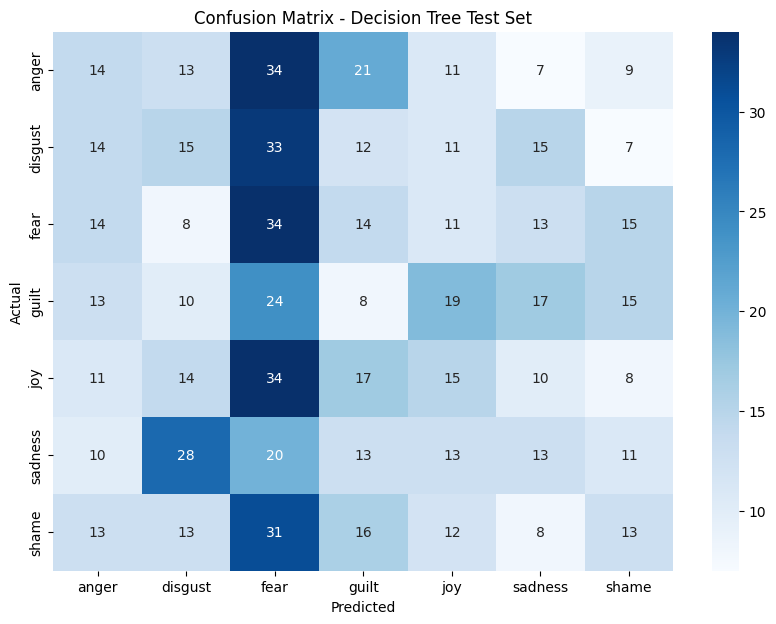

Updated Test Metrics DataFrame with Decision Tree Results:


,Model,Preprocessing,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Logistic Regression,Method 2,TF-IDF,0.556637,0.148541,0.138506,0.148279,0.141081,"{'classifier__C': 1, 'classifier__class_weight..."
0,Dummy Classifier,NaN,TFIDF,0.144395,0.144562,0.020652,0.142857,0.036087,{'classifier__strategy': 'most_frequent'}
0,Logistic Regression,Method 1,TF-IDF,0.572124,0.151194,0.155677,0.151122,0.147817,"{'classifier__C': 0.5, 'classifier__class_weig..."
0,Decision Tree,Method 2,TFIDF,0.556637,0.148541,0.147610,0.148093,0.143256,"{'classifier__class_weight': None, 'classifier..."


In [40]:
# Preprocess the text data
X_train_preprocessed = [preprocess_text_1(text, "porter") for text in X_train]
X_test_preprocessed = [preprocess_text_1(text, "porter") for text in X_test]

# Step 1: Apply TF-IDF vectorization **before the pipeline**
X_train_tfidf = tfidf_transformer(X_train_preprocessed)  # Precompute TF-IDF embeddings
X_test_tfidf = tfidf_transformer(X_test_preprocessed)

pipeline_dt = Pipeline(
    [
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

# Parameter grid for GridSearchCV
param_grid_dt = {
    "classifier__criterion": ["gini", "entropy"],  # Splitting criteria
    "classifier__max_depth": [None, 10, 20, 30, 50, 100],  # Maximum depth of the tree
    "classifier__min_samples_split": [
        2,
        3,
        5,
        10,
    ],  # Minimum number of samples required to split
    "classifier__min_samples_leaf": [1, 2, 4, 5],  # Minimum number of samples per leaf
    "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
}

print("Starting Grid Search for Decision Tree...")


grid_search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the preprocessed training data
grid_search_dt.fit(X_train_tfidf, y_train)

# Get the best parameters
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_
print("Best parameters found:", best_params_dt)
print("Best F1 score (from Grid Search):", best_score_dt)

# Step 5: Fit the final model on the training data with the best hyperparameters
pipeline_dt.set_params(**best_params_dt)
pipeline_dt.fit(X_train_tfidf, y_train)

# Step 6: Evaluate the model on the test set
print("Evaluating Decision Tree on Test set...")
y_test_pred_dt = pipeline_dt.predict(X_test_tfidf)

# Print classification report for the test set
test_report_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)
print("\nDecision Tree Test Classification Report:")
print(classification_report(y_test, y_test_pred_dt))

# Confusion matrix for the test set
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt, labels=pipeline_dt.classes_)
cm_test_df_dt = pd.DataFrame(
    cm_test_dt, index=pipeline_dt.classes_, columns=pipeline_dt.classes_
)

# Plot the confusion matrix for the test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_dt, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Decision Tree Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 7: Extract metrics for the test set
test_metrics_data_dt = {
    "Model": ["Decision Tree"],
    "Vectorizer": ["TFIDF"],
    "Preprocessing": ["Method 2"],
    "Best F1 Score (CV)": best_score,
    "Test Accuracy": [test_report_dt["accuracy"]],
    "Test Macro Precision": [test_report_dt["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_dt["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_dt["macro avg"]["f1-score"]],
    "Best Parameters": [best_params_dt],
}

# Convert the metrics to a DataFrame
test_metrics_df_dt_tfidf = pd.DataFrame(test_metrics_data_dt)

test_metrics_df = pd.concat([test_metrics_df, test_metrics_df_dt_tfidf])

# Display the DataFrame with the test metrics
print("Updated Test Metrics DataFrame with Decision Tree Results:")
display(test_metrics_df)

Starting Grid Search for Decision Tree...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best parameters found: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Best F1 score (from Grid Search): 0.4554572271386431
Evaluating Decision Tree on Test set...

Decision Tree Test Classification Report:
              precision    recall  f1-score   support

       anger       0.16      0.09      0.12       109
     disgust       0.22      0.15      0.18       107
        fear       0.18      0.20      0.19       109
       guilt       0.13      0.27      0.18       106
         joy       0.08      0.06      0.07       109
     sadness       0.11      0.06      0.08       108
       shame       0.18      0.23      0.20       106

    accuracy                           0.15       754
   macro avg       0.15      0.15      0.15       754
weighted avg       0.15

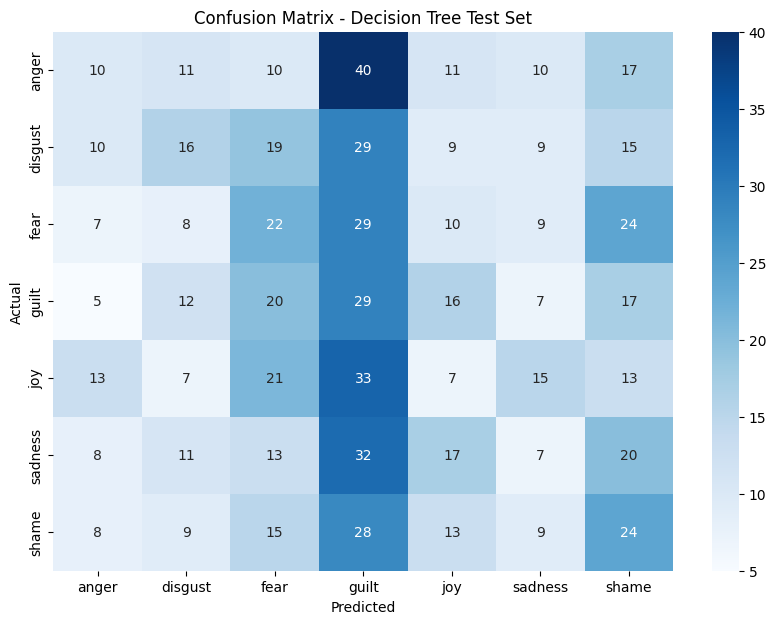

Updated Test Metrics DataFrame with Decision Tree Results:


,Model,Preprocessing,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Logistic Regression,Method 2,TF-IDF,0.556637,0.148541,0.138506,0.148279,0.141081,"{'classifier__C': 1, 'classifier__class_weight..."
0,Dummy Classifier,NaN,TFIDF,0.144395,0.144562,0.020652,0.142857,0.036087,{'classifier__strategy': 'most_frequent'}
0,Logistic Regression,Method 1,TF-IDF,0.572124,0.151194,0.155677,0.151122,0.147817,"{'classifier__C': 0.5, 'classifier__class_weig..."
0,Decision Tree,Method 2,TFIDF,0.556637,0.148541,0.147610,0.148093,0.143256,"{'classifier__class_weight': None, 'classifier..."
0,Decision Tree,Method 2,TFIDF,0.556637,0.152520,0.152902,0.153164,0.145895,"{'classifier__class_weight': None, 'classifier..."


In [42]:
# Preprocess the text data
X_train_preprocessed = [preprocess_text_2(text) for text in X_train]
X_test_preprocessed = [preprocess_text_2(text) for text in X_test]

# Step 1: Apply TF-IDF vectorization **before the pipeline**
X_train_tfidf = tfidf_transformer(X_train_preprocessed)  # Precompute TF-IDF embeddings
X_test_tfidf = tfidf_transformer(X_test_preprocessed)

pipeline_dt = Pipeline(
    [
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

# Parameter grid for GridSearchCV
param_grid_dt = {
    "classifier__criterion": ["gini", "entropy"],  # Splitting criteria
    "classifier__max_depth": [None, 10, 20, 30, 50, 100],  # Maximum depth of the tree
    "classifier__min_samples_split": [
        2,
        3,
        5,
        10,
    ],  # Minimum number of samples required to split
    "classifier__min_samples_leaf": [1, 2, 4, 5],  # Minimum number of samples per leaf
    "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
}

print("Starting Grid Search for Decision Tree...")


grid_search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the preprocessed training data
grid_search_dt.fit(X_train_tfidf, y_train)

# Get the best parameters
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_
print("Best parameters found:", best_params_dt)
print("Best F1 score (from Grid Search):", best_score_dt)

# Step 5: Fit the final model on the training data with the best hyperparameters
pipeline_dt.set_params(**best_params_dt)
pipeline_dt.fit(X_train_tfidf, y_train)

# Step 6: Evaluate the model on the test set
print("Evaluating Decision Tree on Test set...")
y_test_pred_dt = pipeline_dt.predict(X_test_tfidf)

# Print classification report for the test set
test_report_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)
print("\nDecision Tree Test Classification Report:")
print(classification_report(y_test, y_test_pred_dt))

# Confusion matrix for the test set
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt, labels=pipeline_dt.classes_)
cm_test_df_dt = pd.DataFrame(
    cm_test_dt, index=pipeline_dt.classes_, columns=pipeline_dt.classes_
)

# Plot the confusion matrix for the test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_dt, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Decision Tree Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 7: Extract metrics for the test set
test_metrics_data_dt = {
    "Model": ["Decision Tree"],
    "Vectorizer": ["TFIDF"],
    "Preprocessing": ["Method 2"],
    "Best F1 Score (CV)": best_score,
    "Test Accuracy": [test_report_dt["accuracy"]],
    "Test Macro Precision": [test_report_dt["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_dt["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_dt["macro avg"]["f1-score"]],
    "Best Parameters": [best_params_dt],
}

# Convert the metrics to a DataFrame
test_metrics_df_dt_tfidf = pd.DataFrame(test_metrics_data_dt)

test_metrics_df = pd.concat([test_metrics_df, test_metrics_df_dt_tfidf])

# Display the DataFrame with the test metrics
print("Updated Test Metrics DataFrame with Decision Tree Results:")
display(test_metrics_df)

#### 3.1.2. Random Forests Classifier.

### 3.2. Models with `GloVe`

#### 3.2.0. Logistic Regression.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd


# GloVe vectorizer function
def glove_transformer(corpus):
    return glove_vec_preprocessed(corpus, glove_embeddings)


# Preprocess the text data
X_train_preprocessed = [preprocess_text(text, "porter") for text in X_train]
X_test_preprocessed = [preprocess_text(text, "porter") for text in X_test]

# Step 1: Apply GloVe vectorization **before the pipeline**
X_train_glove = glove_transformer(X_train_preprocessed)  # Precompute GloVe embeddings
X_test_glove = glove_transformer(X_test_preprocessed)

# Step 2: Create the pipeline (without the GloVe vectorization step)
pipeline = Pipeline(
    [
        ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
    ]
)

# Step 3: Define the parameter grid for GridSearchCV
param_grid = {
    "classifier__C": [
        0.01,
        0.05,
        0.1,
        0.2,
        0.5,
        1,
    ],  # Logistic Regression hyperparameters
    "classifier__penalty": [
        "l2",
        "l1",
        "elasticnet",
        None,
    ],  # Removed "elasticnet" unless solver='saga' is used
    "classifier__class_weight": ["balanced", None],
    "classifier__solver": ["newton-cg", "sag", "saga", "lbfgs"],
}

print("Starting Grid Search for Logistic Regression...")

# Step 4: Perform Grid Search using GridSearchCV on the **precomputed GloVe embeddings**
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the precomputed GloVe embeddings (X_train_glove)
grid_search.fit(X_train_glove, y_train)

# Step 5: Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters found:", best_params)
print("Best F1 score (from Grid Search):", best_score)

# Step 6: Fit the final model on the training data with the best hyperparameters
pipeline.set_params(**best_params)
pipeline.fit(X_train_glove, y_train)

# Step 7: Evaluate the model on the test set (using precomputed GloVe embeddings)
print("Evaluating Logistic Regression on Test set...")
y_test_pred = pipeline.predict(X_test_glove)

# Print classification report for the test set
test_report = classification_report(y_test, y_test_pred, output_dict=True)
print("\nLogistic Regression Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Step 8: Extract metrics for the test set
test_metrics_data = {
    "Model": ["Logistic Regression"],
    "Vectorizer": ["GloVe"],
    "Best F1 Score (CV)": best_score,
    "Test Accuracy": [test_report["accuracy"]],
    "Test Macro Precision": [test_report["macro avg"]["precision"]],
    "Test Macro Recall": [test_report["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report["macro avg"]["f1-score"]],
    "Best Parameters": [best_params],
}

# Convert the metrics to a DataFrame
test_metrics_df = pd.DataFrame(test_metrics_data)

test_metrics_df = pd.concat([results_dummy_df, test_metrics_df])

# Display the DataFrame with the test metrics
print("Updated Test Metrics DataFrame with Logistic Regression Results:")
display(test_metrics_df)


Starting Grid Search for Logistic Regression...
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warni

Best parameters found: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best F1 score (from Grid Search): 0.4404129793510324
Evaluating Logistic Regression on Test set...

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

       anger       0.31      0.25      0.28       109
     disgust       0.44      0.45      0.44       107
        fear       0.58      0.62      0.60       109
       guilt       0.30      0.29      0.30       106
         joy       0.47      0.59      0.52       109
     sadness       0.51      0.56      0.53       108
       shame       0.36      0.28      0.32       106

    accuracy                           0.44       754
   macro avg       0.42      0.43      0.43       754
weighted avg       0.42      0.44      0.43       754

Updated Test Metrics DataFrame with Logistic Regression Results:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
classifier__strategy,Dummy Classifier,GloVe,0.144395,0.144562,0.020652,0.142857,0.036087,most_frequent
0,Logistic Regression,GloVe,0.440413,0.435013,0.423799,0.434049,0.426636,"{'classifier__C': 1, 'classifier__class_weight..."


#### 3.1.1. Decision Tree Clasifier.

Starting Grid Search for Decision Tree...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


Best parameters found: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
Best F1 score (from Grid Search): 0.26297935103244835
Evaluating Decision Tree on Test set...

Decision Tree Test Classification Report:
              precision    recall  f1-score   support

       anger       0.18      0.13      0.15       109
     disgust       0.29      0.30      0.29       107
        fear       0.29      0.29      0.29       109
       guilt       0.18      0.38      0.25       106
         joy       0.34      0.25      0.29       109
     sadness       0.35      0.34      0.35       108
       shame       0.25      0.12      0.16       106

    accuracy                           0.26       754
   macro avg       0.27      0.26      0.25       754
weighted avg       0.27      0.26      0.25       754



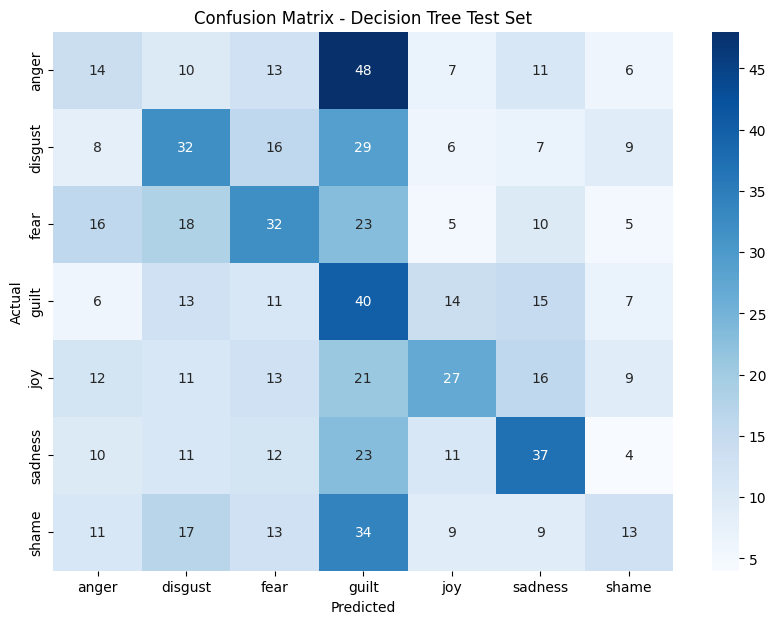

Updated Test Metrics DataFrame with Decision Tree Results:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
classifier__strategy,Dummy Classifier,GloVe,0.144395,0.144562,0.020652,0.142857,0.036087,most_frequent
0,Logistic Regression,GloVe,0.440413,0.435013,0.423799,0.434049,0.426636,"{'classifier__C': 1, 'classifier__class_weight..."
0,Decision Tree,Tf-IDF,0.262979,0.258621,0.268766,0.258769,0.254300,"{'classifier__class_weight': None, 'classifier..."


In [26]:
pipeline_dt = Pipeline(
    [
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)


param_grid_dt = {
    "classifier__criterion": ["gini", "entropy"],  # Splitting criteria
    "classifier__max_depth": [None, 10, 20, 30, 50, 100],  # Maximum depth of the tree
    "classifier__min_samples_split": [2, 3, 5, 10],  # Minimum samples required to split
    "classifier__min_samples_leaf": [1, 2, 4, 5],  # Minimum number of samples per leaf
    "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
}

print("Starting Grid Search for Decision Tree...")


grid_search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the preprocessed training data
grid_search_dt.fit(X_train_glove, y_train)

# Get the best parameters
best_params_dt = grid_search_dt.best_params_
best_score = grid_search_dt.best_score_
print("Best parameters found:", best_params_dt)
print("Best F1 score (from Grid Search):", best_score)

# Step 5: Fit the final model on the training data with the best hyperparameters
pipeline_dt.set_params(**best_params_dt)
pipeline_dt.fit(X_train_glove, y_train)

# Step 6: Evaluate the model on the test set
print("Evaluating Decision Tree on Test set...")
y_test_pred_dt = pipeline_dt.predict(X_test_glove)

# Print classification report for the test set
test_report_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)
print("\nDecision Tree Test Classification Report:")
print(classification_report(y_test, y_test_pred_dt))

# Confusion matrix for the test set
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt, labels=pipeline_dt.classes_)
cm_test_df_dt = pd.DataFrame(
    cm_test_dt, index=pipeline_dt.classes_, columns=pipeline_dt.classes_
)

# Plot the confusion matrix for the test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_dt, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Decision Tree Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 7: Extract metrics for the test set
test_metrics_data_dt = {
    "Model": ["Decision Tree"],
    "Vectorizer": ["Tf-IDF"],
    "Best F1 Score (CV)": best_score,
    "Test Accuracy": [test_report_dt["accuracy"]],
    "Test Macro Precision": [test_report_dt["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_dt["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_dt["macro avg"]["f1-score"]],
    "Best Parameters": [best_params_dt],
}

# Convert the metrics to a DataFrame
test_metrics_df_dt = pd.DataFrame(test_metrics_data_dt)

test_metrics_df = pd.concat([test_metrics_df, test_metrics_df_dt])

# Display the DataFrame with the test metrics
print("Updated Test Metrics DataFrame with Decision Tree Results:")
display(test_metrics_df)

### 3.1. Models with `tfidf Vectorizer`

#### 3.1.1. Decision Tree Clasifier

Starting Grid Search for Decision Tree...
Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
Best parameters found: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'vectorizer__max_features': 1000}
Best F1 score (from Grid Search): 0.47352064865950927
Evaluating Decision Tree on Test set...

Decision Tree Test Classification Report:
              precision    recall  f1-score   support

       anger       0.32      0.29      0.30       109
     disgust       0.46      0.52      0.49       107
        fear       0.56      0.59      0.57       109
       guilt       0.37      0.39      0.38       106
         joy       0.56      0.50      0.52       109
     sadness       0.51      0.56      0.53       108
       shame       0.41      0.35      0.38       106

    accuracy                           0.46       754
   macro avg       0.45      0.46      0.

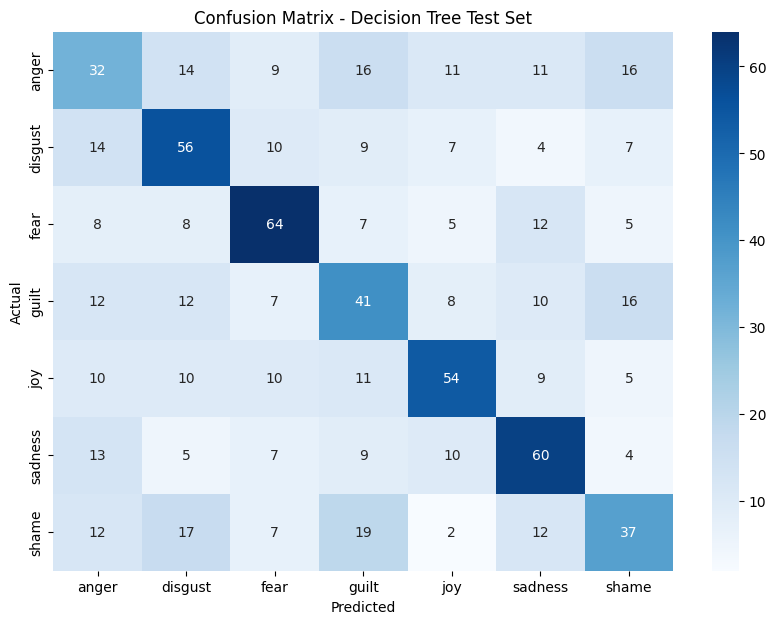

Updated Test Metrics DataFrame with Decision Tree Results:


,Model,Vectorizer,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Decision Tree,Tf-IDF,0.456233,0.45423,0.455845,0.453826,"{'classifier__class_weight': None, 'classifier..."


In [24]:
def preprocess_pipeline(texts, stemmer="porter"):
    return [preprocess_text(text, stemmer) for text in texts]


# Preprocess the text data
X_train_preprocessed = preprocess_pipeline(X_train)
X_test_preprocessed = preprocess_pipeline(X_test)

pipeline_dt = Pipeline(
    [
        ("vectorizer", tfidf_vec(max_features=500)),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

# Parameter grid for GridSearchCV
param_grid_dt = {
    "vectorizer__max_features": [
        100,
        500,
        1000,
        1500,
    ],  # Different sizes of TF-IDF features
    "classifier__criterion": ["gini", "entropy"],  # Splitting criteria
    "classifier__max_depth": [None, 10, 20, 30, 50, 100],  # Maximum depth of the tree
    "classifier__min_samples_split": [
        2,
        3,
        5,
        10,
    ],  # Minimum number of samples required to split
    "classifier__min_samples_leaf": [1, 2, 4, 5],  # Minimum number of samples per leaf
    "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
}

print("Starting Grid Search for Decision Tree...")


grid_search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the preprocessed training data
grid_search_dt.fit(X_train_preprocessed, y_train)

# Get the best parameters
best_params_dt = grid_search_dt.best_params_
print("Best parameters found:", best_params_dt)
print("Best F1 score (from Grid Search):", grid_search_dt.best_score_)

# Step 5: Fit the final model on the training data with the best hyperparameters
pipeline_dt.set_params(**best_params_dt)
pipeline_dt.fit(X_train_preprocessed, y_train)

# Step 6: Evaluate the model on the test set
print("Evaluating Decision Tree on Test set...")
y_test_pred_dt = pipeline_dt.predict(X_test_preprocessed)

# Print classification report for the test set
test_report_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)
print("\nDecision Tree Test Classification Report:")
print(classification_report(y_test, y_test_pred_dt))

# Confusion matrix for the test set
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt, labels=pipeline_dt.classes_)
cm_test_df_dt = pd.DataFrame(
    cm_test_dt, index=pipeline_dt.classes_, columns=pipeline_dt.classes_
)

# Plot the confusion matrix for the test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_dt, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Decision Tree Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 7: Extract metrics for the test set
test_metrics_data_dt = {
    "Model": ["Decision Tree"],
    "Vectorizer": ["Tf-IDF"],
    "Test Accuracy": [test_report_dt["accuracy"]],
    "Test Macro Precision": [test_report_dt["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_dt["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_dt["macro avg"]["f1-score"]],
    "Best Parameters": [best_params_dt],
}

# Convert the metrics to a DataFrame
test_metrics_df = pd.DataFrame(test_metrics_data_dt)

# Display the DataFrame with the test metrics
print("Updated Test Metrics DataFrame with Decision Tree Results:")
display(test_metrics_df)

#### 3.1.2. Random Forests Classifier.

Starting Grid Search for Decision Tree...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best parameters found: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200, 'vectorizer__max_features': 1500}
Best F1 score (from Grid Search): 0.5489210598437922
Evaluating Decision Tree on Test set...

Random Forest Test Classification Report:
              precision    recall  f1-score   support

       anger       0.45      0.41      0.43       109
     disgust       0.60      0.64      0.62       107
        fear       0.61      0.72      0.66       109
       guilt       0.40      0.41      0.40       106
         joy       0.56      0.71      0.63       109
     sadness       0.65      0.56      0.60       108
       shame       0.60      0.41      0.48       106

    accuracy                           0.55       754
   macro avg       0.55      0.55  

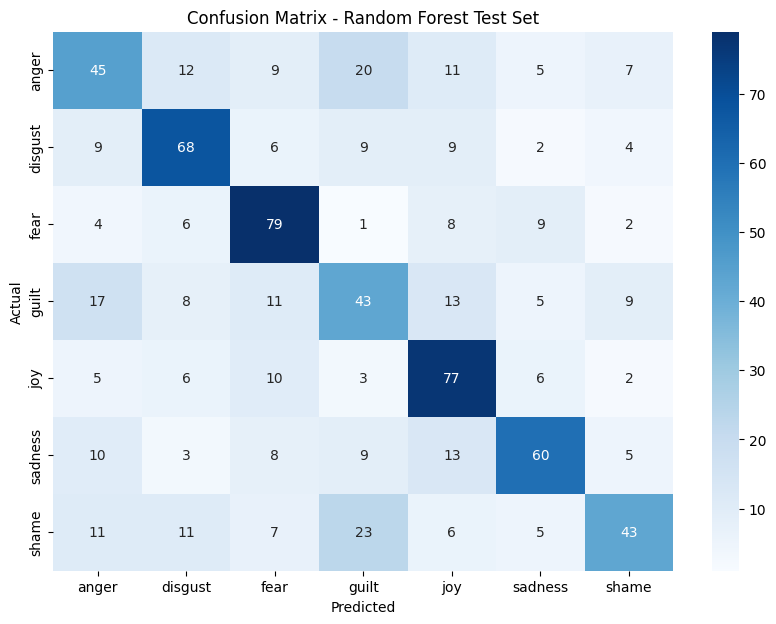

Final Test Metrics DataFrame with Decision Tree and Random Forest Results:


,Model,Vectorizer,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Decision Tree,Tf-IDF,0.456233,0.454230,0.455845,0.453826,"{'classifier__class_weight': None, 'classifier..."
1,Random Forest,Tf-IDF,0.550398,0.551331,0.549490,0.545154,"{'classifier__class_weight': 'balanced', 'clas..."


In [27]:
def preprocess_pipeline(texts, stemmer="porter"):
    return [preprocess_text(text, stemmer) for text in texts]


# Preprocess the text data
X_train_preprocessed = preprocess_pipeline(X_train)
X_test_preprocessed = preprocess_pipeline(X_test)

pipeline_rf = Pipeline(
    [
        ("vectorizer", tfidf_vec(max_features=500)),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Parameter grid for GridSearchCV
param_grid_rf = {
    "vectorizer__max_features": [500, 1000, 1500],  # Different sizes of TF-IDF features
    "classifier__n_estimators": [50, 100, 200],  # Number of trees in the forest
    "classifier__max_depth": [None, 10, 30, 50, 100],  # Maximum depth of the tree
    "classifier__min_samples_split": [
        2,
        3,
        5,
        10,
    ],  # Minimum number of samples required to split
    "classifier__min_samples_leaf": [1, 2, 4],  # Minimum number of samples per leaf
    "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
}


print("Starting Grid Search for Decision Tree...")


grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the preprocessed training data
grid_search_rf.fit(X_train_preprocessed, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters found:", best_params_rf)
print("Best F1 score (from Grid Search):", grid_search_rf.best_score_)

# Step 5: Fit the final model on the training data with the best hyperparameters
pipeline_rf.set_params(**best_params_rf)
pipeline_rf.fit(X_train_preprocessed, y_train)

# Step 6: Evaluate the model on the test set
print("Evaluating Decision Tree on Test set...")
y_test_pred_rf = pipeline_rf.predict(X_test_preprocessed)

# Print classification report for the test set for Random Forest
test_report_rf = classification_report(y_test, y_test_pred_rf, output_dict=True)
print("\nRandom Forest Test Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

# Confusion matrix for the test set for Random Forest
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf, labels=pipeline_rf.classes_)
cm_test_df_rf = pd.DataFrame(
    cm_test_rf, index=pipeline_rf.classes_, columns=pipeline_rf.classes_
)

# Plot the confusion matrix for the Random Forest test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_rf, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Random Forest Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 6: Extract metrics for the test set for Random Forest
test_metrics_data_rf = {
    "Model": ["Random Forest"],
    "Vectorizer": ["Tf-IDF"],
    "Test Accuracy": [test_report_rf["accuracy"]],
    "Test Macro Precision": [test_report_rf["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_rf["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_rf["macro avg"]["f1-score"]],
    "Best Parameters": [best_params_rf],
}

# Convert the metrics to a DataFrame for Random Forest
test_metrics_df_rf = pd.DataFrame(test_metrics_data_rf)

# Step 7: Append the Random Forest results to the Decision Tree results
final_test_metrics_df = pd.concat(
    [test_metrics_df, test_metrics_df_rf], ignore_index=True
)

# Display the final DataFrame with the test metrics for both models
print("Final Test Metrics DataFrame with Decision Tree and Random Forest Results:")
display(final_test_metrics_df)

### 3.1.3. Support Vector Classifier (SVC)

Starting Grid Search for Support Vector Classifier...
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


Best parameters found for Support Vector Classifier: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'vectorizer__max_features': 1500}
Best F1 score (from Grid Search for Support Vector Classifier): 0.5571505616551709
Evaluating Support Vector Classifier on Test set...

Support Vector Classifier Test Classification Report:
              precision    recall  f1-score   support

       anger       0.47      0.56      0.51       109
     disgust       0.61      0.64      0.62       107
        fear       0.73      0.69      0.71       109
       guilt       0.48      0.49      0.48       106
         joy       0.66      0.70      0.68       109
     sadness       0.67      0.55      0.60       108
       shame       0.56      0.52      0.54       106

    accuracy                           0.59       754
   macro avg       0.60      0.59      0.59       754
weighted avg       0.60      0.59      0.59       754



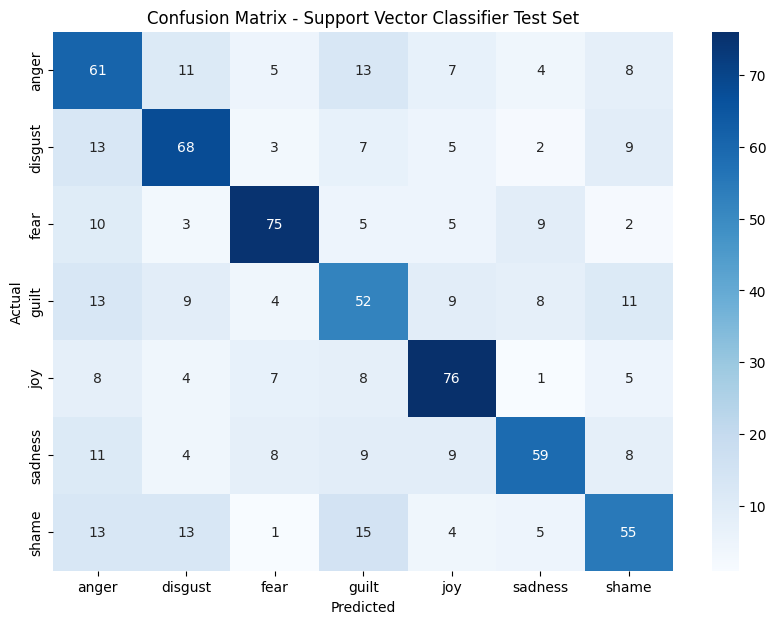

Final Test Metrics DataFrame with Decision Tree, Random Forest, and Support Vector Classifier Results:


,Model,Vectorizer,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Decision Tree,Tf-IDF,0.456233,0.454230,0.455845,0.453826,"{'classifier__class_weight': None, 'classifier..."
1,Random Forest,Tf-IDF,0.550398,0.551331,0.549490,0.545154,"{'classifier__class_weight': 'balanced', 'clas..."
2,Support Vector Classifier,Tf-IDF,0.591512,0.596826,0.590885,0.592101,"{'classifier__C': 1, 'classifier__class_weight..."


In [28]:
# Step 1: Define the SVC pipeline
pipeline_svc = Pipeline(
    [
        (
            "vectorizer",
            tfidf_vec(max_features=500),
        ),  # Placeholder for TF-IDF vectorizer
        ("classifier", SVC(random_state=42)),
    ]
)

# Step 2: Parameter grid for GridSearchCV for SVC
param_grid_svc = {
    "vectorizer__max_features": [
        100,
        500,
        1000,
        1500,
    ],  # Different sizes of TF-IDF features
    "classifier__C": [0.1, 0.5, 1, 5, 10],  # Regularization parameter
    "classifier__kernel": ["linear", "poly", "rbf", "sigmoid"],  # Kernel type
    "classifier__gamma": ["scale", "auto"],  # Kernel coefficient
    "classifier__class_weight": [None, "balanced"],
}

print("Starting Grid Search for Support Vector Classifier...")

# Step 3: Perform Grid Search using GridSearchCV for SVC
grid_search_svc = GridSearchCV(
    pipeline_svc,
    param_grid_svc,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the preprocessed training data for SVC
grid_search_svc.fit(X_train_preprocessed, y_train)

# Get the best parameters for SVC
best_params_svc = grid_search_svc.best_params_
print("Best parameters found for Support Vector Classifier:", best_params_svc)
print(
    "Best F1 score (from Grid Search for Support Vector Classifier):",
    grid_search_svc.best_score_,
)

# Step 4: Fit the final model on the training data with the best hyperparameters
pipeline_svc.set_params(**best_params_svc)
pipeline_svc.fit(X_train_preprocessed, y_train)

# Step 5: Evaluate the SVC model on the test set
print("Evaluating Support Vector Classifier on Test set...")
y_test_pred_svc = pipeline_svc.predict(X_test_preprocessed)

# Print classification report for the test set for SVC
test_report_svc = classification_report(y_test, y_test_pred_svc, output_dict=True)
print("\nSupport Vector Classifier Test Classification Report:")
print(classification_report(y_test, y_test_pred_svc))

# Confusion matrix for the test set for SVC
cm_test_svc = confusion_matrix(y_test, y_test_pred_svc, labels=pipeline_svc.classes_)
cm_test_df_svc = pd.DataFrame(
    cm_test_svc, index=pipeline_svc.classes_, columns=pipeline_svc.classes_
)

# Plot the confusion matrix for the SVC test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_svc, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Support Vector Classifier Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 6: Extract metrics for the test set for SVC
test_metrics_data_svc = {
    "Model": ["Support Vector Classifier"],
    "Vectorizer": ["Tf-IDF"],
    "Test Accuracy": [test_report_svc["accuracy"]],
    "Test Macro Precision": [test_report_svc["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_svc["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_svc["macro avg"]["f1-score"]],
    "Best Parameters": [best_params_svc],
}

# Convert the metrics to a DataFrame for SVC
test_metrics_df_svc = pd.DataFrame(test_metrics_data_svc)

# Step 7: Append the SVC results to the final DataFrame with previous results
final_test_metrics_df = pd.concat(
    [final_test_metrics_df, test_metrics_df_svc], ignore_index=True
)

# Display the final DataFrame with the test metrics for all models
print(
    "Final Test Metrics DataFrame with Decision Tree, Random Forest, and Support Vector Classifier Results:"
)
display(final_test_metrics_df)


### 3.2. Models with `word2vec`

#### 3.2.1. Decision Tree Clasifier.

In [41]:
# Word2Vec Vectorizer for preprocessed text (fixed configuration)
def word2vec_vec_preprocessed_fixed(corpus):
    return word2vec_vec_preprocessed(
        corpus, vector_size=100, window=5, min_count=1, sg=0
    )


# Preprocess the text data
X_train_preprocessed = preprocess_pipeline(X_train)
X_test_preprocessed = preprocess_pipeline(X_test)

# Apply Word2Vec vectorization with fixed configuration
X_train_w2v = word2vec_vec_preprocessed_fixed(X_train_preprocessed)
X_test_w2v = word2vec_vec_preprocessed_fixed(X_test_preprocessed)

# Step 1: Define the pipeline for the classifier
pipeline_dt = Pipeline(
    [
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

# Step 2: Define the parameter grid for GridSearchCV for the Decision Tree
param_grid_dt = {
    "classifier__criterion": ["gini", "entropy"],  # Splitting criteria
    "classifier__max_depth": [None, 10, 20, 30, 50, 100],  # Maximum depth of the tree
    "classifier__min_samples_split": [
        2,
        3,
        5,
        10,
    ],  # Minimum number of samples required to split
    "classifier__min_samples_leaf": [1, 2, 4, 5],  # Minimum number of samples per leaf
    "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
}

print("Starting Grid Search for Decision Tree...")

# Step 3: Perform Grid Search using GridSearchCV
grid_search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    cv=5,  # 5-fold cross-validation
    scoring="f1_micro",  # F1 score metric
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Fit GridSearchCV on the vectorized training data
grid_search_dt.fit(X_train_w2v, y_train)

# Step 4: Get the best parameters
best_params_dt = grid_search_dt.best_params_
print("Best parameters found:", best_params_dt)
print("Best F1 score (from Grid Search):", grid_search_dt.best_score_)

# Step 5: Fit the final model on the training data with the best hyperparameters
pipeline_dt.set_params(**best_params_dt)
pipeline_dt.fit(X_train_w2v, y_train)

# Step 6: Evaluate the model on the test set
print("Evaluating Decision Tree on Test set...")
y_test_pred_dt = pipeline_dt.predict(X_test_w2v)

# Print classification report for the test set
test_report_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)
print("\nDecision Tree Test Classification Report:")
print(classification_report(y_test, y_test_pred_dt))

# Confusion matrix for the test set
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt, labels=pipeline_dt.classes_)
cm_test_df_dt = pd.DataFrame(
    cm_test_dt, index=pipeline_dt.classes_, columns=pipeline_dt.classes_
)

# Plot the confusion matrix for the test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_dt, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Decision Tree Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 7: Extract metrics for the test set
test_metrics_data_dt = {
    "Model": ["Decision Tree"],
    "Vectorizer": ["Word2Vec (Fixed Configuration)"],
    "Test Accuracy": [test_report_dt["accuracy"]],
    "Test Macro Precision": [test_report_dt["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_dt["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_dt["macro avg"]["f1-score"]],
    "Best Parameters": [best_params_dt],
}

# Convert the metrics to a DataFrame
test_metrics_df_dt = pd.DataFrame(test_metrics_data_dt)

final_test_metrics_df = pd.concat([final_test_metrics_df, test_metrics_df_dt])

# Display the DataFrame with the test metrics
print("Updated Test Metrics DataFrame with Decision Tree Results:")
display(final_test_metrics_df)

Starting Grid Search for Decision Tree...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


KeyboardInterrupt: 

### Evaluation of Machine Learning Models

Based on the metrics against test set and using **Macro F1-Score** decision criteria, the best Machine Learning to clasificate Text in Emotions is **SVC** with a **Macro F1-Score** of 0.582579

In [36]:
final_test_metrics_df.head()

,Model,Vectorizer,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Decision Tree,Tf-IDF,0.456233,0.454230,0.455845,0.453826,"{'classifier__class_weight': None, 'classifier..."
1,Random Forest,Tf-IDF,0.550398,0.551331,0.549490,0.545154,"{'classifier__class_weight': 'balanced', 'clas..."
2,Support Vector Classifier,Tf-IDF,0.591512,0.596826,0.590885,0.592101,"{'classifier__C': 1, 'classifier__class_weight..."


In [18]:
test_metrics_df.to_excel("../data/model_results/ml_models.xlsx", index=False)